# Code Data Profiling with Data Prep Kit

This notebook provides a comprehensive guide for profiling code data across 21 programming languages, focusing on extracting both syntactic and semantic concepts from the input dataset. This notebook guides you through running `code_profiler` transformation using the data-prep-kit.

Pure python (run locally): this notebook
   - **Input:** Parquet file with columns `language` (Programming language of the code snippet) and `contents` (code snippet). If you have raw source code in a directory you can convert it into a parquet using the `transforms/code/code2parquet` transform 
   - **Output:** Annotated parquet file with higher-order syntactic concepts and a graphical report of the distribution of Library, Language, Semantic Functional Category, and CCR (Code Complexity Rate) based on the input dataset.
     
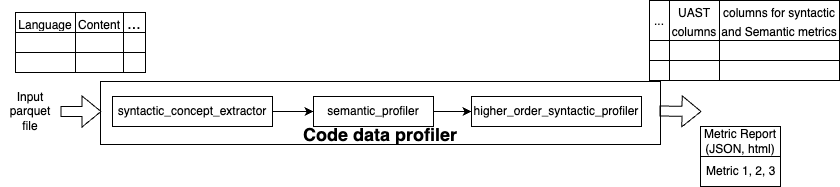

## Step 0: Setting up Python Dev Environment
Please follow instructions from [Getting started](https://github.com/IBM/data-prep-kit/blob/4171dfa00cf7bfe166fd30072ad8ec4c8cde6967/README.md#gettingstarted) section to setup your python development environment

## Step 1: Input the dataset information to the `code profiler`

a. If you have the input parquet file on your local machine, copy it to the `code_profiler_input_dir` folder. DPK also supports downloading input parquet from the COS.

In [ ]:
# Specify the target directory where your transforms Makefile, input and output are located
user_local_dir = '/root'

transforms_dir = user_local_dir + '/data-prep-kit/transforms'

'''
Copy your input parquet file containing the raw source code to `code_profiler_input_dir`.
Assign the parquet filename and specify the column names for the raw code and language in the file
transforms/code/syntactic_concept_extractor/input/data_profiler_params.json.
'''
code_profiler_input_dir = transforms_dir + '/code/code_profiler/input'
print(code_profiler_input_dir)

## Step 2: `Code profiler` extracts the syntactic and semantic concepts from the input dataset

This cell has some utility functions for executing the transform.


In [ ]:
import os
import subprocess
from IPython.core.display import display, HTML
import shutil
import pandas as pd
import json
from IPython.display import display

# Following are the utility functions for running the transforms sequencially

def run_make_command(target_dir, command):
    """Function to change directory and run a make command with real-time log output."""
    if os.path.exists(target_dir):
        # Change the current working directory to the target directory
        os.chdir(target_dir)
        print(f"Changed directory to: {os.getcwd()}")

        # Run the make command and stream logs
        try:
            process = subprocess.Popen(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
            for stdout_line in iter(process.stdout.readline, ""):
                print(stdout_line, end="")  # Print stdout line-by-line in real-time
            process.stdout.close()
            process.wait()

            # Check for errors and handle stderr
            if process.returncode != 0:
                print("Error Output:")
                for stderr_line in iter(process.stderr.readline, ""):
                    print(stderr_line, end="")
                process.stderr.close()
            else:
                print("Process completed successfully.")
        except subprocess.CalledProcessError as e:
            print(f"Error occurred while running the make command: {e}")
    else:
        print(f"Directory does not exist: {target_dir}")

def check_directories_exist(directories):
    results = {}
    for directory in directories:
        if os.path.isdir(directory):
            print(f"The directory '{directory}' exists.")
            results[directory] = True
        else:
            print(f"The directory '{directory}' does not exist.")
            results[directory] = False
    return results

def display_html_file(hosp_code_dir):
    # Construct the path to the HTML file
    html_file_path = os.path.join(hosp_code_dir, 'src', 'output.html')
    
    # Check if the file exists
    if not os.path.exists(html_file_path):
        raise FileNotFoundError(f"The file '{html_file_path}' does not exist.")
    
    # Read the HTML file
    with open(html_file_path, 'r', encoding='utf-8') as file:
        html_content = file.read()
    
    # Display the HTML content in the notebook
    display(HTML(html_content))
    
def display_value_counts_from_json(file_path, metric_index, column_name):
    """
    Function to load a JSON file, extract the value counts for a specified metric,
    and display the counts in descending order.

    Parameters:
    file_path (str): Path to the JSON file.
    metric_index (int): The index of the 'metrics' list from which to extract 'value_counts'.
    column_name (str): The name of the column to be displayed (e.g., "Library", "Language", "Semantic Functional Category").
    """
    # Step 1: Read JSON file
    with open(file_path, 'r') as f:
        data_dict = json.load(f)
    
    # Step 2: Extract the "value_counts" field from the JSON structure
    value_counts = data_dict["metrics"][metric_index]["value_counts"]
    
    # Step 3: Convert the "value_counts" dictionary to a pandas DataFrame
    df = pd.DataFrame(list(value_counts.items()), columns=[column_name, "Count"])
    
    # Step 4: Drop rows where any value in the row is NaN
    df_cleaned = df.dropna(how="any")  # This drops any row where any column has NaN
    
    # Step 5: Sort the DataFrame by "Count" in descending order
    df_cleaned_sorted = df_cleaned.sort_values(by="Count", ascending=False)
    
    # Step 6: Display the cleaned and sorted DataFrame
    display(df_cleaned_sorted)

code_profiler_code_dir = transforms_dir + '/code/code_profiler/python'
code_profiler_output_dir = transforms_dir + '/code/code_profiler/output'

directories_to_check = [code_profiler_input_dir, code_profiler_code_dir, code_profiler_output_dir]
check_results = check_directories_exist(directories_to_check)

print("Checking directory exists or not")
for directory, exists in check_results.items():
    print(f"{directory}: {'Exists' if exists else 'Does not exist'}")
    
    if not exists:
        if 'output' in directory:
            os.makedirs(directory, exist_ok=True)
            print(f"Directory '{directory}' did not exist, so it was created.")
        else:
            raise FileNotFoundError(f"The directory '{directory}' does not exist.")

def clean_directory(directory):
    # Check if the directory exists
    if os.path.exists(directory):
        # Change the current working directory to the target directory
        os.chdir(directory)
        print(f"Changed directory to: {os.getcwd()}")
        
        # List files before cleaning
        run_make_command(directory, ['ls', '-la'])
        
        # Attempt to remove all files and directories, including hidden ones
        run_make_command(directory, ['rm', '-rf', '*'])
        
        # List files after cleaning to verify
        run_make_command(directory, ['ls', '-la'])
        
        print("Directory cleaned successfully.")
    else:
        print(f"Directory does not exist: {directory}")

# Clean the output directory
# clean_directory(code_profiler_output_dir)

In [ ]:
# runnning the syntactic_concept_extractor transform
run_make_command(code_profiler_code_dir, ['make', 'venv'])
run_make_command(code_profiler_code_dir, ['make', 'run-local-python-sample'])

## Step 3: Metrics report generated from the output dataframe of the profilers

##### Goto the folder `transforms/code/code_profiler/python/src` to view the JSON file (output*.json) and it's rendered graphical html report (starting with output*.html) showing the distribution of the following example metrics. 
- Library
- Language
- Semantic Functional Category
- CCR (Code Complexity Rate)
